In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Bil468_Gürcan/Project


Mounted at /content/drive
/content/drive/MyDrive/Bil468_Gürcan/Project


In [ ]:
# !unzip ./Data/fer2013.zip -d ./Data

In [2]:
def load_images_from_folder(folder, max_images_per_class=None, flatten=True):
    images = []
    labels = []
    for label_folder in os.listdir(folder):
        label_folder_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_folder_path):
            count_images_for_class = 0
            print("label_folder_path: ", label_folder_path)
            for image_file in os.listdir(label_folder_path):
                if max_images_per_class is not None and count_images_for_class >= max_images_per_class:
                    print(f"Reached maximum number of images for class {label_folder}. Skipping the rest.")
                    break
                count_images_for_class += 1
                image_path = os.path.join(label_folder_path, image_file)
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (48, 48))
                if flatten:
                    images.append(img.flatten())
                else:
                    images.append(img)
                labels.append(label_folder)
    return np.array(images), np.array(labels)

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For 2 folder splittet data => merges them
def prepare_X_y(dataset_name = 'fer2013', max_images_per_class=None):
    if dataset_name == 'fer2013':
        train_folder = './Data/fer2013/train'
        test_folder = './Data/fer2013/validation'
    else:
        train_folder = './Data/Expw-F_sample500/train'
        test_folder = './Data/Expw-F_sample500/validation'
    images_train, labels_train = load_images_from_folder(train_folder, max_images_per_class, flatten=False)
    images_test, labels_test = load_images_from_folder(test_folder, max_images_per_class, flatten=False)
    X = np.concatenate((images_train, images_test), axis=0)
    y = np.concatenate((labels_train, labels_test), axis=0)
    return X, y

In [4]:
X, y = prepare_X_y(dataset_name='fer2013', max_images_per_class=None)

label_folder_path:  ./Data/fer2013/train/happy
label_folder_path:  ./Data/fer2013/train/sad
label_folder_path:  ./Data/fer2013/train/fear
label_folder_path:  ./Data/fer2013/train/surprise
label_folder_path:  ./Data/fer2013/train/neutral
label_folder_path:  ./Data/fer2013/train/angry
label_folder_path:  ./Data/fer2013/train/disgust
label_folder_path:  ./Data/fer2013/validation/angry
label_folder_path:  ./Data/fer2013/validation/disgust
label_folder_path:  ./Data/fer2013/validation/neutral
label_folder_path:  ./Data/fer2013/validation/surprise
label_folder_path:  ./Data/fer2013/validation/happy
label_folder_path:  ./Data/fer2013/validation/sad
label_folder_path:  ./Data/fer2013/validation/fear


In [5]:
from collections import Counter
class_counts = Counter(y)
print(class_counts)

Counter({'happy': 8989, 'neutral': 6198, 'sad': 6077, 'angry': 4953, 'fear': 4721, 'surprise': 4002, 'disgust': 547})


In [6]:
# one hot encode labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(y)

label_dict = {k: v for k, v in enumerate(lb.classes_)}


In [7]:
print(label_dict)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [36]:
from collections import Counter
X_reshaped = X.reshape((X.shape[0], 48, 48,1))


# X_train, X_test, y_train, y_test = train_test_split(X_reshaped, labels, test_size=0.1, shuffle=False, stratify=labels)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=labels)

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, labels, test_size=0.1, shuffle=True, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(1/9), shuffle=True, stratify=y_train)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
class_counts_train = Counter(np.argmax(y_train , axis = 1 ))
class_counts_val = Counter(np.argmax(y_val , axis = 1 ))
class_counts_test = Counter(np.argmax(y_test , axis = 1 ))
print(" train: ", class_counts_train,"\n val: ", class_counts_val, "\n test: ", class_counts_test)

(28389, 48, 48, 1)
(3549, 48, 48, 1)
(3549, 48, 48, 1)
 train:  Counter({3: 7191, 4: 4958, 5: 4861, 0: 3963, 2: 3777, 6: 3202, 1: 437}) 
 val:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55}) 
 test:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55})


In [37]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True)

In [38]:
datagen.fit(X_train)
valgen.fit(X_val)

In [39]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

# Desing Model

In [40]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# CNN MODEL - 1

In [41]:
def build_model():

    model= tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(7, activation='softmax'))
    model.compile(
      optimizer = Adam(lr=0.0001),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
    return model

In [42]:
model = build_model()
model.compile(
    optimizer = Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall'])

In [43]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [44]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
443/444 [============================>.] - ETA: 0s - loss: 6.9961 - accuracy: 0.2147 - precision: 0.2306 - recall: 0.0383
Epoch 1: val_accuracy improved from -inf to 0.25218, saving model to best_model.h5
444/444 [==============================] - 26s 44ms/step - loss: 6.9867 - accuracy: 0.2147 - precision: 0.2306 - recall: 0.0383 - val_loss: 2.7045 - val_accuracy: 0.2522 - val_precision: 0.3252 - val_recall: 0.0831
Epoch 2/30
444/444 [==============================] - ETA: 0s - loss: 2.5741 - accuracy: 0.3018 - precision: 0.5287 - recall: 0.0838
Epoch 2: val_accuracy improved from 0.25218 to 0.31784, saving model to best_model.h5
444/444 [==============================] - 21s 47ms/step - loss: 2.5741 - accuracy: 0.3018 - precision: 0.5287 - recall: 0.0838 - val_loss: 2.6005 - val_accuracy: 0.3178 - val_precision: 0.7006 - val_recall: 0.0930
Epoch 3/30
443/444 [============================>.] - ETA: 0s - loss: 2.6050 - accuracy: 0.4073 - precision: 0.6773 - recall: 0.1880
Ep

# Visualize results

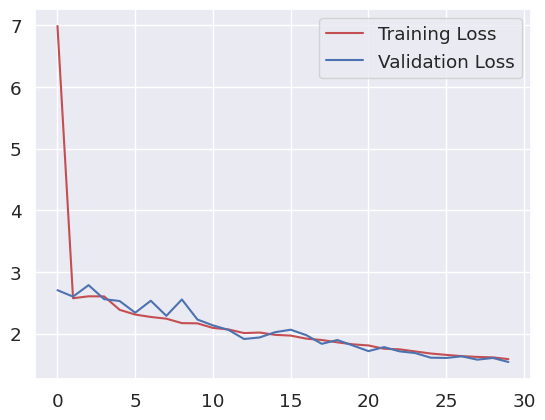

In [45]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

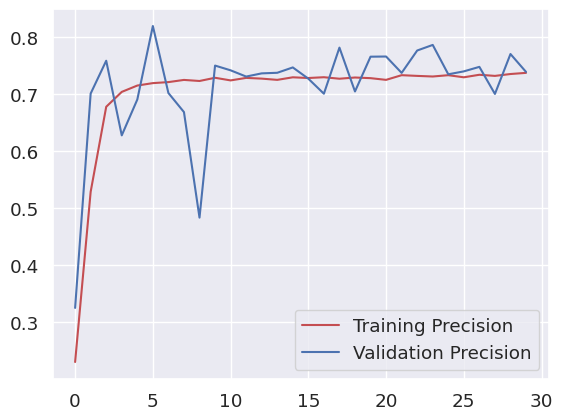

In [53]:
plt.plot(history.history["precision"],'r', label="Training Precision")
plt.plot(history.history["val_precision"],'b', label="Validation Precision")
plt.legend()

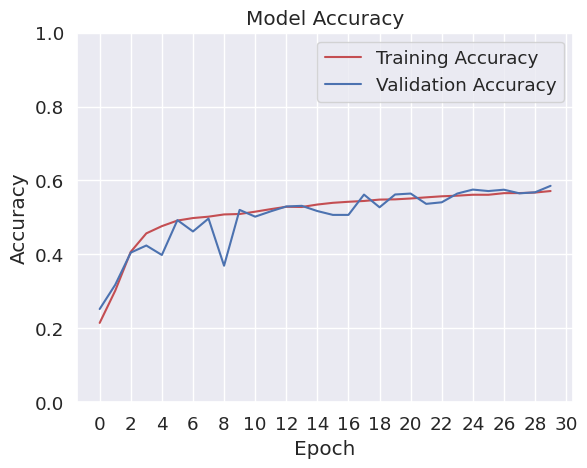

In [47]:
epochs = 30
plt.plot(history.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history.history["val_accuracy"], 'b', label="Validation Accuracy")

plt.ylim(0.0, 1.0)
plt.xticks(np.arange(0, epochs + 2, 2))

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [48]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

111/111 [==============================] - 0s 3ms/step


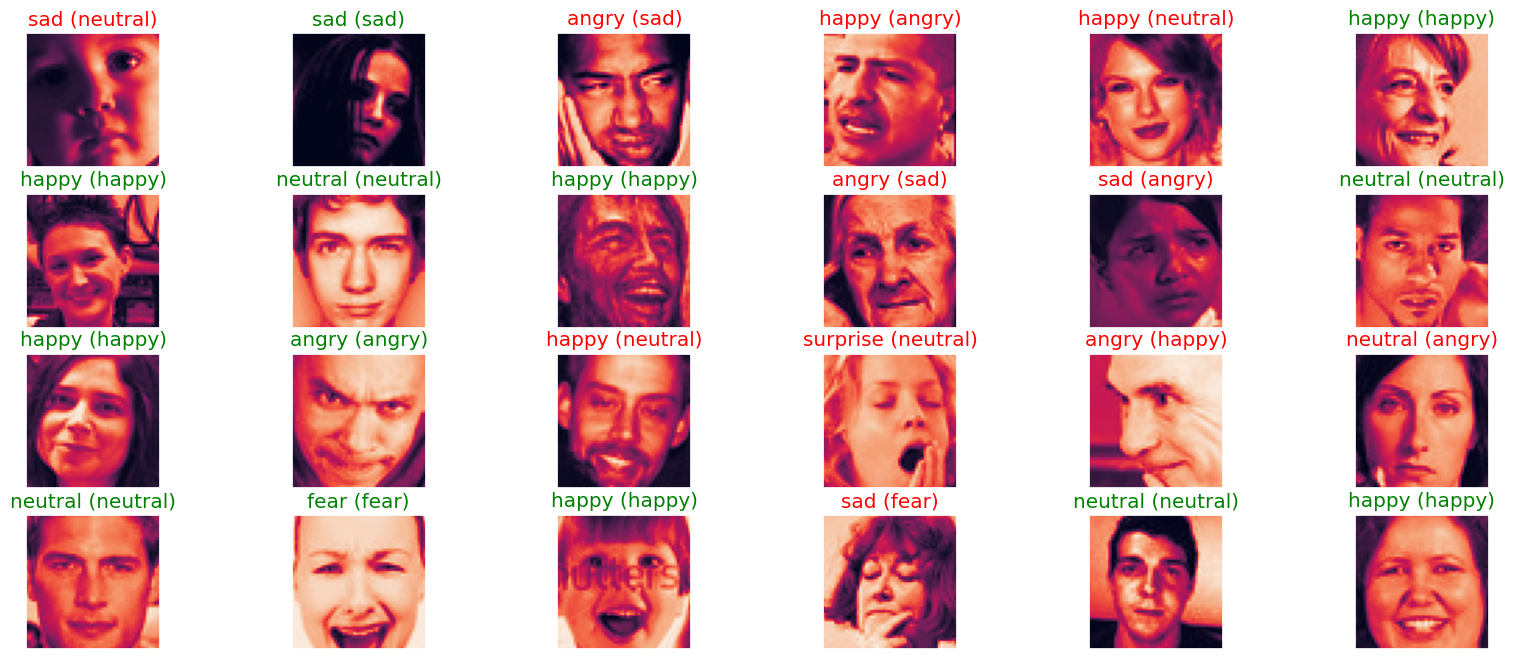

In [52]:
# label_dict = {k: v for k, v in enumerate(lb.classes_)}

# {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [50]:
from collections import Counter
class_counts_predict = Counter(y_pred)
class_counts_test = Counter(np.argmax(y_test , axis = 1 ))
print("predict: ", class_counts_predict, " test: ", class_counts_test)

predict:  Counter({3: 946, 5: 828, 4: 745, 6: 492, 0: 461, 2: 77})  test:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55})


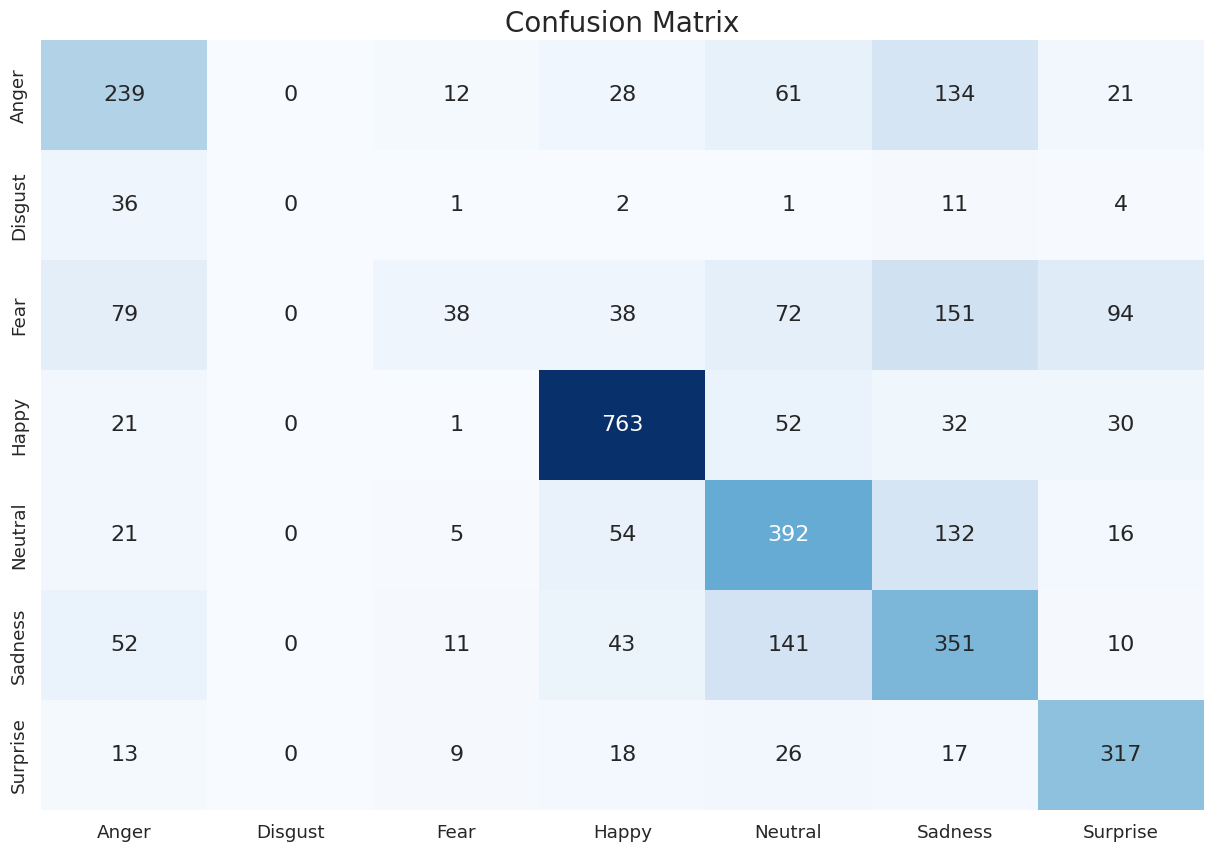

In [51]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels=range(len(CLASS_LABELS)))

cm = pd.DataFrame(cm_data, index=CLASS_LABELS, columns=CLASS_LABELS)

plt.figure(figsize=(15,10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()


In [55]:
loss_train = model.evaluate(X_train,y_train)
loss_val = model.evaluate(X_val,y_val)
loss_test = model.evaluate(X_test,y_test)
print("Train Acc: " + str(loss_train[1]), "Vall Acc: " + str(loss_val[1]), "Test Acc: " + str(loss_test[1]))

111/111 [==============================] - 1s 5ms/step - loss: 1.5212 - accuracy: 0.5917 - precision: 0.7380 - recall: 0.4317
Train Acc: 0.6081933379173279 Vall Acc: 0.5897436141967773 Test Acc: 0.5917159914970398


Processing ./Data/fer2013/train/happy/27599.jpg...
1/1 [==============================] - 0s 38ms/step


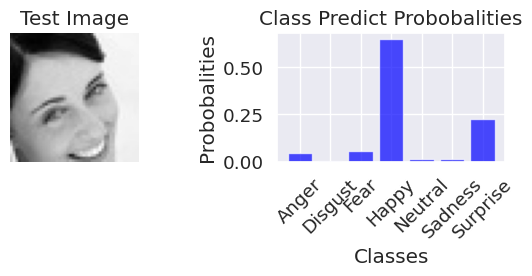

Processing ./Data/fer2013/train/happy/1421.jpg...
1/1 [==============================] - 0s 41ms/step


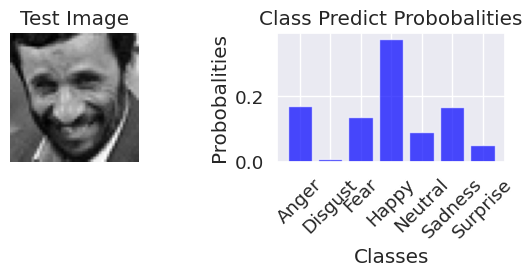

Processing ./Data/fer2013/train/happy/18027.jpg...
1/1 [==============================] - 0s 35ms/step


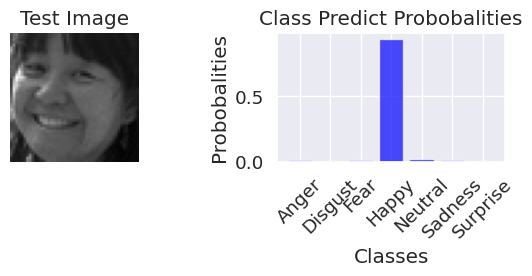

Processing ./Data/fer2013/train/happy/1151.jpg...
1/1 [==============================] - 0s 42ms/step


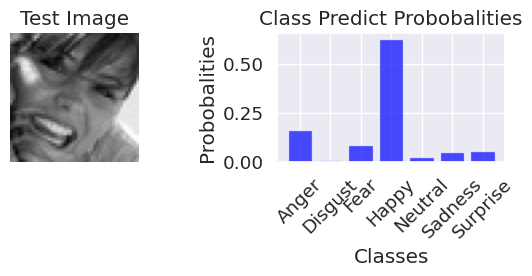

Processing ./Data/fer2013/train/sad/19504.jpg...
1/1 [==============================] - 0s 42ms/step


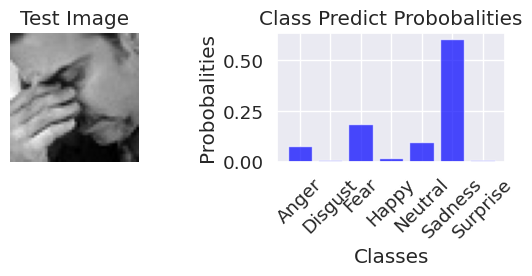

Processing ./Data/fer2013/train/sad/10321.jpg...
1/1 [==============================] - 0s 19ms/step


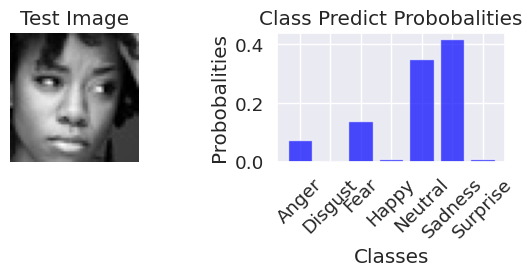

Processing ./Data/fer2013/train/sad/13600.jpg...
1/1 [==============================] - 0s 25ms/step


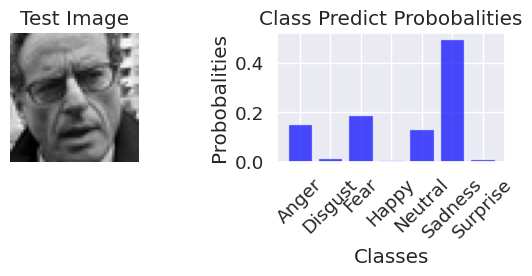

Processing ./Data/fer2013/train/sad/13614.jpg...
1/1 [==============================] - 0s 21ms/step


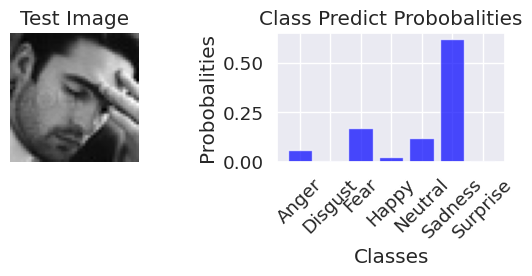

Processing ./Data/fer2013/train/fear/28682.jpg...
1/1 [==============================] - 0s 20ms/step


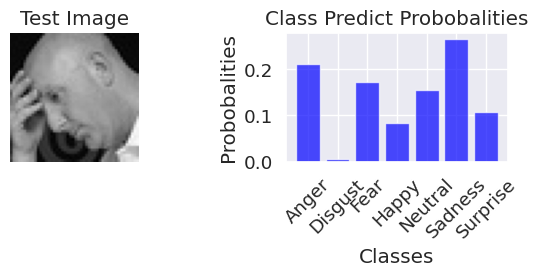

Processing ./Data/fer2013/train/fear/14621.jpg...
1/1 [==============================] - 0s 20ms/step


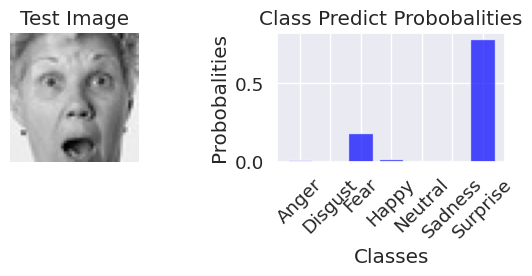

Processing ./Data/fer2013/train/fear/19305.jpg...
1/1 [==============================] - 0s 21ms/step


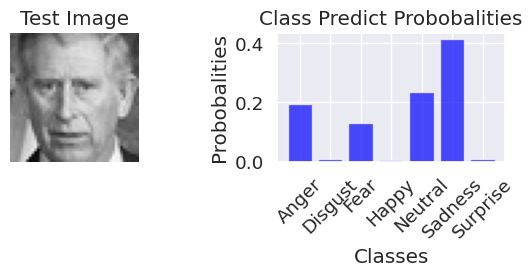

Processing ./Data/fer2013/train/fear/13166.jpg...
1/1 [==============================] - 0s 21ms/step


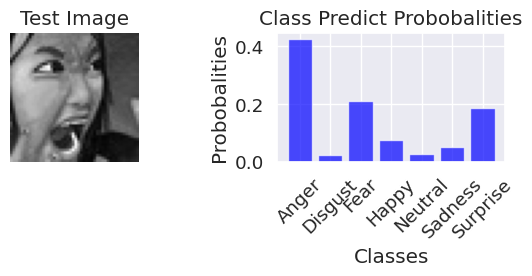

Processing ./Data/fer2013/train/surprise/21895.jpg...
1/1 [==============================] - 0s 20ms/step


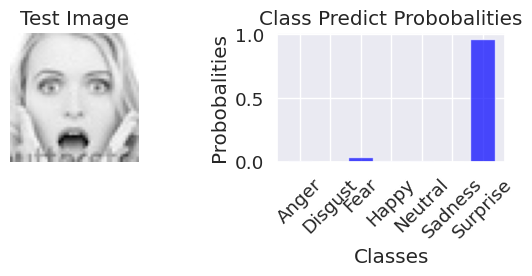

Processing ./Data/fer2013/train/surprise/26136.jpg...
1/1 [==============================] - 0s 20ms/step


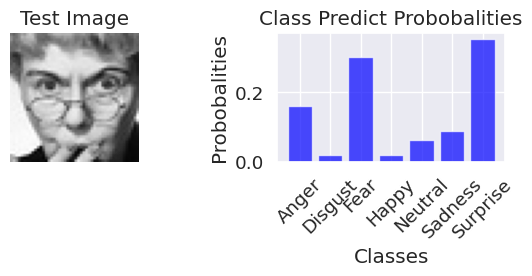

Processing ./Data/fer2013/train/surprise/21856.jpg...
1/1 [==============================] - 0s 32ms/step


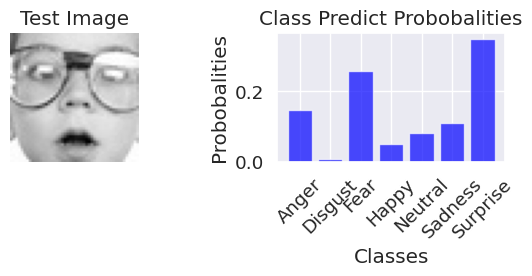

Processing ./Data/fer2013/train/surprise/22393.jpg...
1/1 [==============================] - 0s 29ms/step


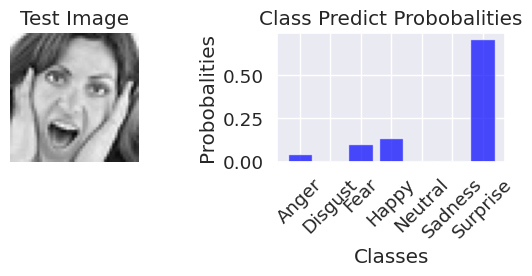

Processing ./Data/fer2013/train/neutral/174.jpg...
1/1 [==============================] - 0s 40ms/step


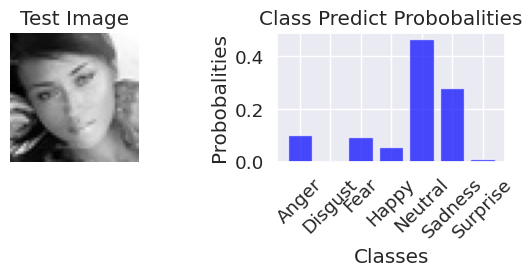

Processing ./Data/fer2013/train/neutral/11983.jpg...
1/1 [==============================] - 0s 47ms/step


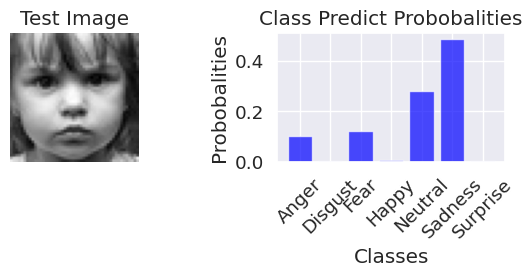

Processing ./Data/fer2013/train/neutral/19307.jpg...
1/1 [==============================] - 0s 33ms/step


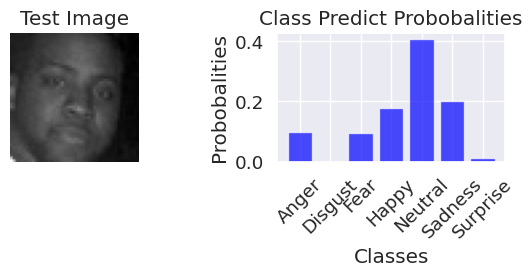

Processing ./Data/fer2013/train/neutral/19061.jpg...
1/1 [==============================] - 0s 21ms/step


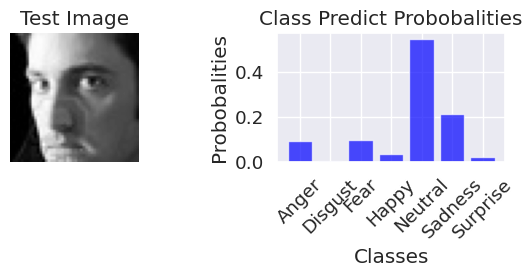

Processing ./Data/fer2013/train/angry/2672.jpg...
1/1 [==============================] - 0s 21ms/step


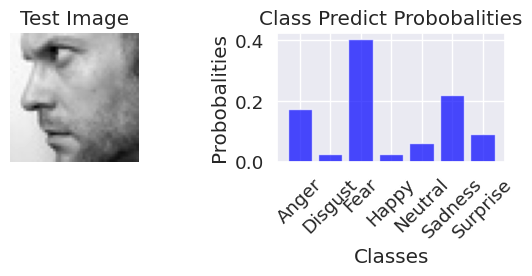

Processing ./Data/fer2013/train/angry/30783.jpg...
1/1 [==============================] - 0s 21ms/step


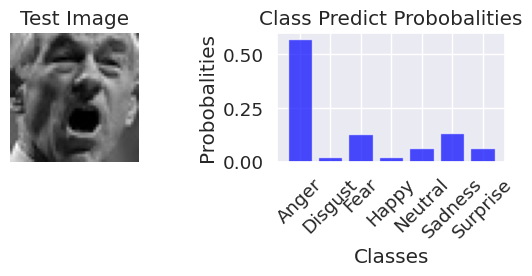

Processing ./Data/fer2013/train/angry/2100.jpg...
1/1 [==============================] - 0s 20ms/step


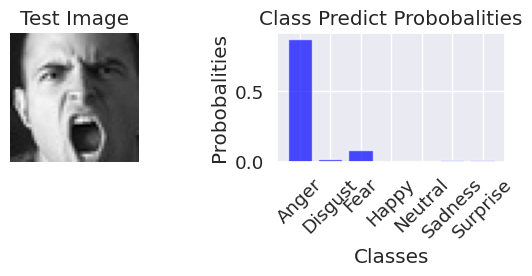

Processing ./Data/fer2013/train/angry/19463.jpg...
1/1 [==============================] - 0s 21ms/step


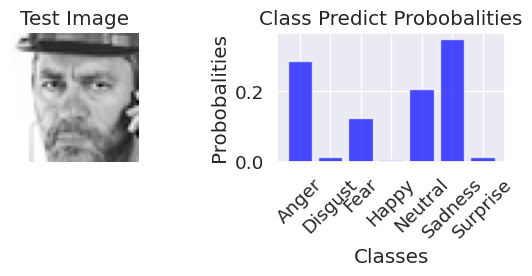

Processing ./Data/fer2013/train/disgust/6548.jpg...
1/1 [==============================] - 0s 20ms/step


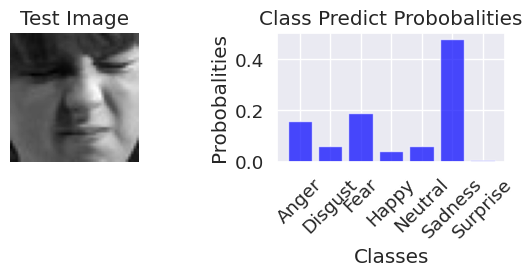

Processing ./Data/fer2013/train/disgust/3626.jpg...
1/1 [==============================] - 0s 20ms/step


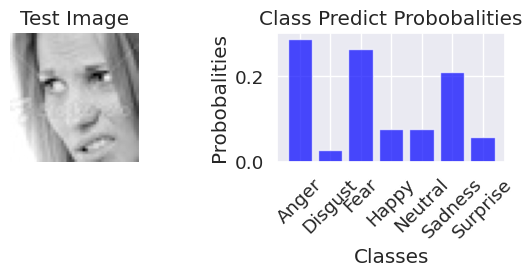

Processing ./Data/fer2013/train/disgust/16591.jpg...
1/1 [==============================] - 0s 19ms/step


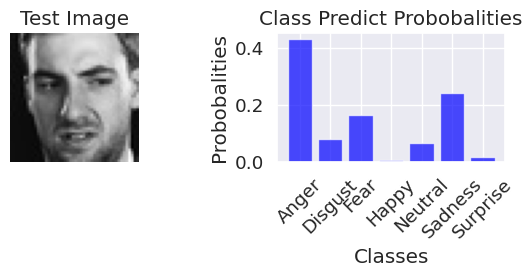

Processing ./Data/fer2013/train/disgust/27201.jpg...
1/1 [==============================] - 0s 23ms/step


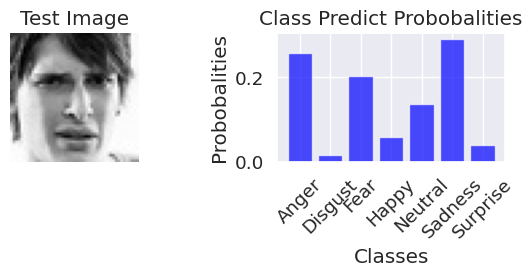

In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

def plot_predictions(predictions, class_labels, image):
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    x_pos = range(len(class_labels))
    plt.bar(x_pos, predictions, align='center', alpha=0.7, color='blue')
    plt.xticks(x_pos, class_labels, rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('Probobalities')
    plt.title('Class Predict Probobalities')

    plt.tight_layout()
    plt.show()

def predict_custom_image(image_path, model):
    img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray_img, (48, 48))

    predictions = model.predict(resized_img.reshape(1, 48, 48, 1))
    custom_predict = predictions[0]

    plot_predictions(custom_predict, CLASS_LABELS, resized_img)

    return predictions[0]

image_list = {
    'happy': [
      '27599',
      '1421',
      '18027',
      '1151'
    ],
    'sad': [
        '19504',
        '10321',
        '13600',
        '13614'
    ],
    'fear': [
        '28682',
        '14621',
        '19305',
        '13166'
    ],
    'surprise': [
        '21895',
        '26136',
        '21856',
        '22393'
    ],
    'neutral': [
        '174',
        '11983',
        '19307',
        '19061'
    ],
    'angry': [
        '2672',
        '30783',
        '2100',
        '19463'
    ],
    'disgust': [
        '6548',
        '3626',
        '16591',
        '27201'
    ],
}
base_path = './Data/fer2013/train/'

for emotion, images in image_list.items():
    for image_name in images:
        image_path = f"{base_path}{emotion}/{image_name}.jpg"
        print(f"Processing {image_path}...")

        custom_prediction = predict_custom_image(image_path, model)

# CNN MODEL - 2

In [62]:
def build_model_2():

    model= tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    return model

In [63]:
model2 = build_model_2()
model2.compile(
      optimizer = Adam(lr=0.00005),
      loss='categorical_crossentropy',
      metrics=['accuracy', 'Precision', 'Recall'])


In [64]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [65]:
history = model2.fit(train_generator,
                    epochs=30,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
443/444 [============================>.] - ETA: 0s - loss: 2.0505 - accuracy: 0.2627 - precision: 0.3005 - recall: 0.0644
Epoch 1: val_accuracy improved from -inf to 0.36095, saving model to best_model.h5
444/444 [==============================] - 21s 41ms/step - loss: 2.0501 - accuracy: 0.2629 - precision: 0.3008 - recall: 0.0644 - val_loss: 1.6363 - val_accuracy: 0.3609 - val_precision: 0.7095 - val_recall: 0.0358
Epoch 2/30
443/444 [============================>.] - ETA: 0s - loss: 1.6426 - accuracy: 0.3667 - precision: 0.6027 - recall: 0.1372
Epoch 2: val_accuracy improved from 0.36095 to 0.38912, saving model to best_model.h5
444/444 [==============================] - 18s 41ms/step - loss: 1.6420 - accuracy: 0.3670 - precision: 0.6030 - recall: 0.1372 - val_loss: 1.5826 - val_accuracy: 0.3891 - val_precision: 0.5415 - val_recall: 0.2079
Epoch 3/30
444/444 [==============================] - ETA: 0s - loss: 1.4759 - accuracy: 0.4365 - precision: 0.6999 - recall: 0.1885
Ep

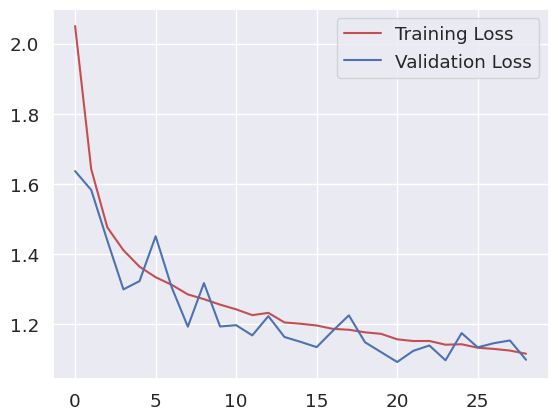

In [66]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

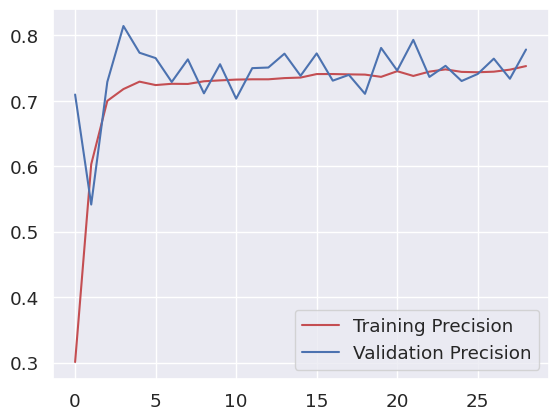

In [67]:
plt.plot(history.history["precision"],'r', label="Training Precision")
plt.plot(history.history["val_precision"],'b', label="Validation Precision")
plt.legend()

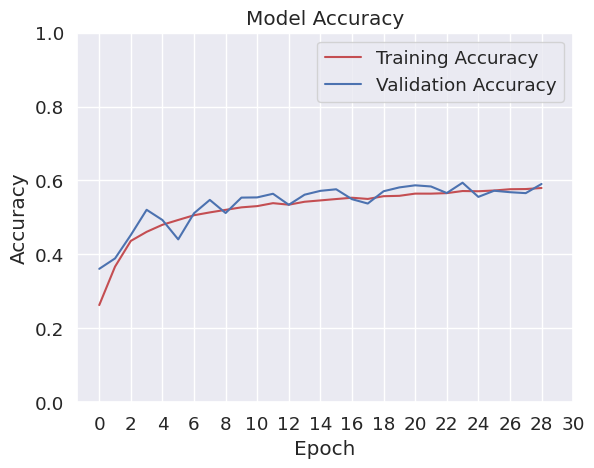

In [68]:
epochs = 30
plt.plot(history.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history.history["val_accuracy"], 'b', label="Validation Accuracy")

plt.ylim(0.0, 1.0)
plt.xticks(np.arange(0, epochs + 2, 2))

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [69]:
preds_2 = model2.predict(X_test)
y_pred_2 = np.argmax(preds , axis = 1 )

111/111 [==============================] - 1s 4ms/step


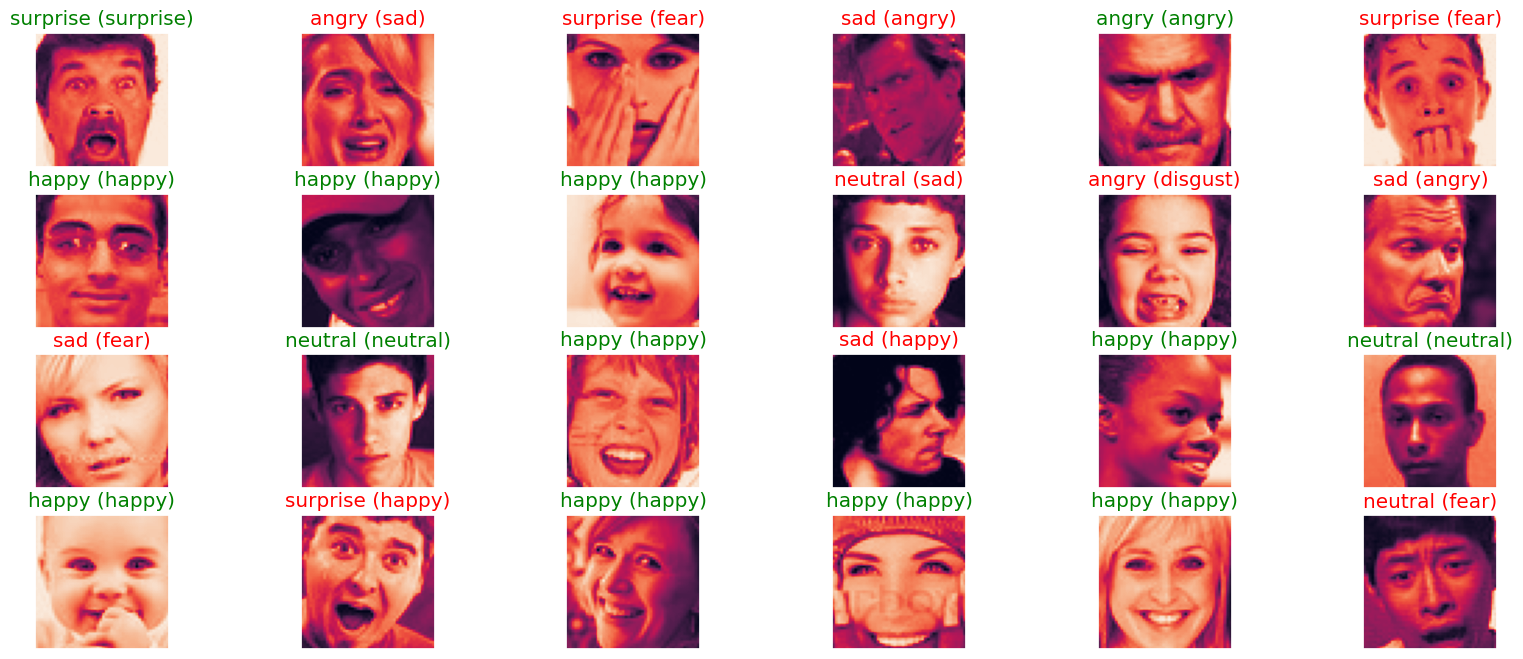

In [70]:
# label_dict = {k: v for k, v in enumerate(lb.classes_)}

# {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred_2[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

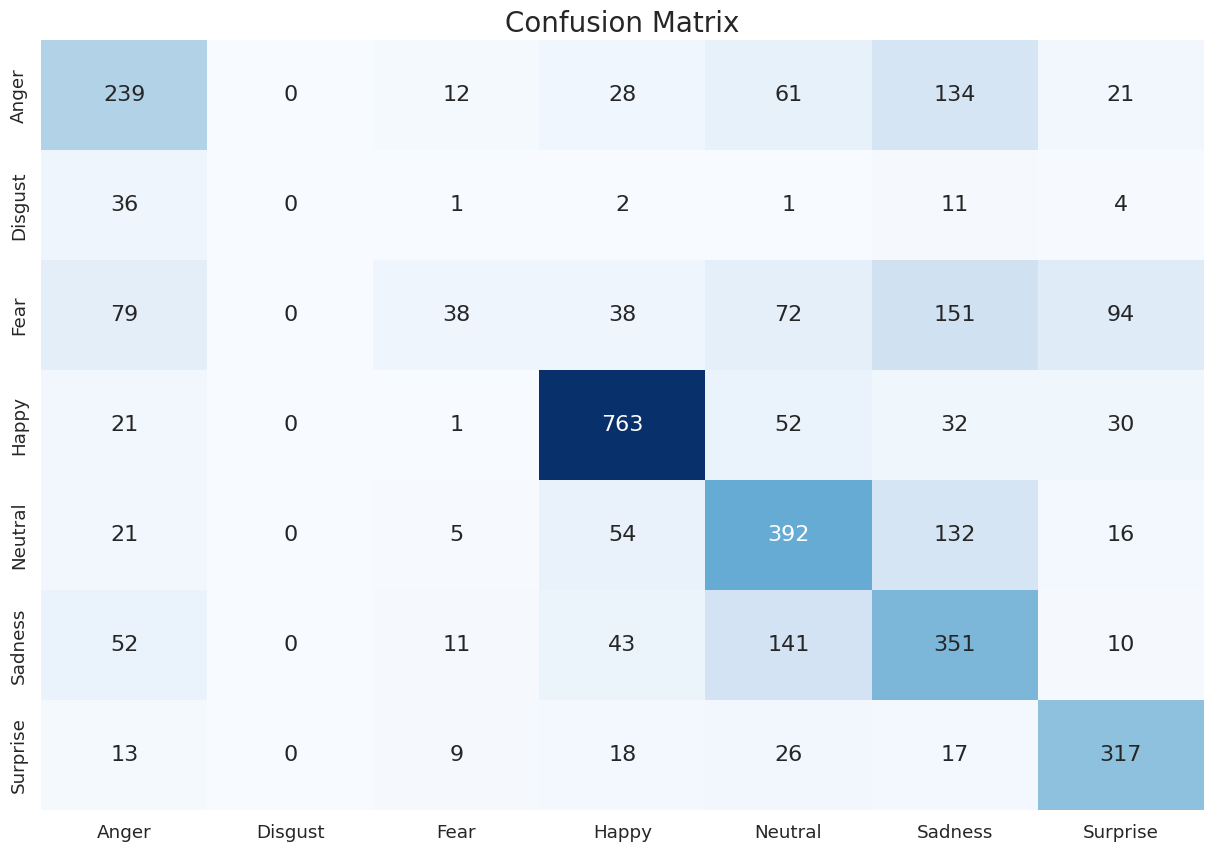

In [71]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred_2, labels=range(len(CLASS_LABELS)))

cm = pd.DataFrame(cm_data, index=CLASS_LABELS, columns=CLASS_LABELS)

plt.figure(figsize=(15,10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()


In [72]:
loss_train_2 = model2.evaluate(X_train,y_train)
loss_val_2 = model2.evaluate(X_val,y_val)
loss_test_2 = model2.evaluate(X_test,y_test)
print("Train Acc: " + str(loss_train_2[1]), "Vall Acc: " + str(loss_val_2[1]), "Test Acc: " + str(loss_test_2[1]))

111/111 [==============================] - 1s 6ms/step - loss: 1.0632 - accuracy: 0.6010 - precision: 0.7565 - recall: 0.4613
Train Acc: 0.6301384568214417 Vall Acc: 0.5990419983863831 Test Acc: 0.6010143756866455


---- old

In [ ]:
# shape = (100,100,3)
shape = (48,48,1)
N = X.shape

X_shaped = X.reshape(N[0], shape[0], shape[1], shape[2])


In [ ]:
import numpy as np

label_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

y_numeric = np.array([label_map[label] for label in y], dtype=np.int64)



In [ ]:
num_class = 7
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_shaped, y_numeric, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [ ]:
from tensorflow.keras import datasets, layers, models

In [ ]:
def build_model(input_shape=(48, 48, 1), conv_filters=[32, 64, 128, 256], dense_neurons=128, dropout_rate=0.2, num_classes=7):
    model = models.Sequential()

    model.add(layers.Conv2D(conv_filters[0], (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(conv_filters[1], (5, 5), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(conv_filters[2], (5, 5), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    if len(conv_filters) > 3:
        model.add(layers.Conv2D(conv_filters[3], (3, 3), activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))


    model.add(layers.Flatten())
    model.add(layers.Dense(dense_neurons, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

    return model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator



dropout_rate_list = [0.2, 0.3]
dense_neurons_list = [128, 256]

conv_filters_list = [
    [32, 64, 128],
    [32, 64, 128, 256]
]

batch_sizes = [32, 64]

results = {}
for conv_filters in conv_filters_list:
    for dropout_rate in dropout_rate_list:
        for dense_neurons in dense_neurons_list:
            for batch_size in batch_sizes:
                model_name = f"model_filters{'-'.join(map(str, conv_filters))}_dropout{dropout_rate}_dense{dense_neurons}_batchsize{batch_size}"
                path_model = f"{model_name}.h5"
                print(f"Training model: {model_name}")

                model = build_model(input_shape=shape, conv_filters=conv_filters,
                                    dropout_rate=dropout_rate,
                                    dense_neurons=dense_neurons,
                                    num_classes=7)

                # history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size,
                #                     validation_data=(X_test, y_test), verbose=2,
                #                     shuffle=True,
                #                     callbacks=[ModelCheckpoint(filepath=path_model)])

                train_datagen = ImageDataGenerator(
                    rescale=1./255, # Normalization
                    rotation_range=20, # Roatate images
                )

                # For test set only normalize
                test_datagen = ImageDataGenerator(rescale=1./255)

                train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
                validation_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

                history = model.fit(
                    train_generator,
                    # steps_per_epoch=len(X_train),
                    verbose=2,
                    epochs=10,
                    validation_data=validation_generator,
                    # validation_steps=len(X_test),
                    # callbacks=[ModelCheckpoint(filepath=path_model)]
                )

                history_dict = {
                    "train_accuracy": history.history['accuracy'][-1],
                    "val_accuracy": history.history['val_accuracy'][-1],
                    "train_precision": history.history['precision'][-1],
                    "val_precision": history.history['val_precision'][-1],
                    "train_recall": history.history['recall'][-1],
                    "val_recall": history.history['val_recall'][-1]
                }
                results[model_name] = history_dict

In [ ]:
# prompt: print results to json file

import json

with open('expw_non_transfer.json', 'w') as f:
    json.dump(results, f)


In [ ]:
with open('./Results/Non-transfer-CNN/expW/expw_non_transfer.json', 'r') as f:
    results_loaded = json.load(f)



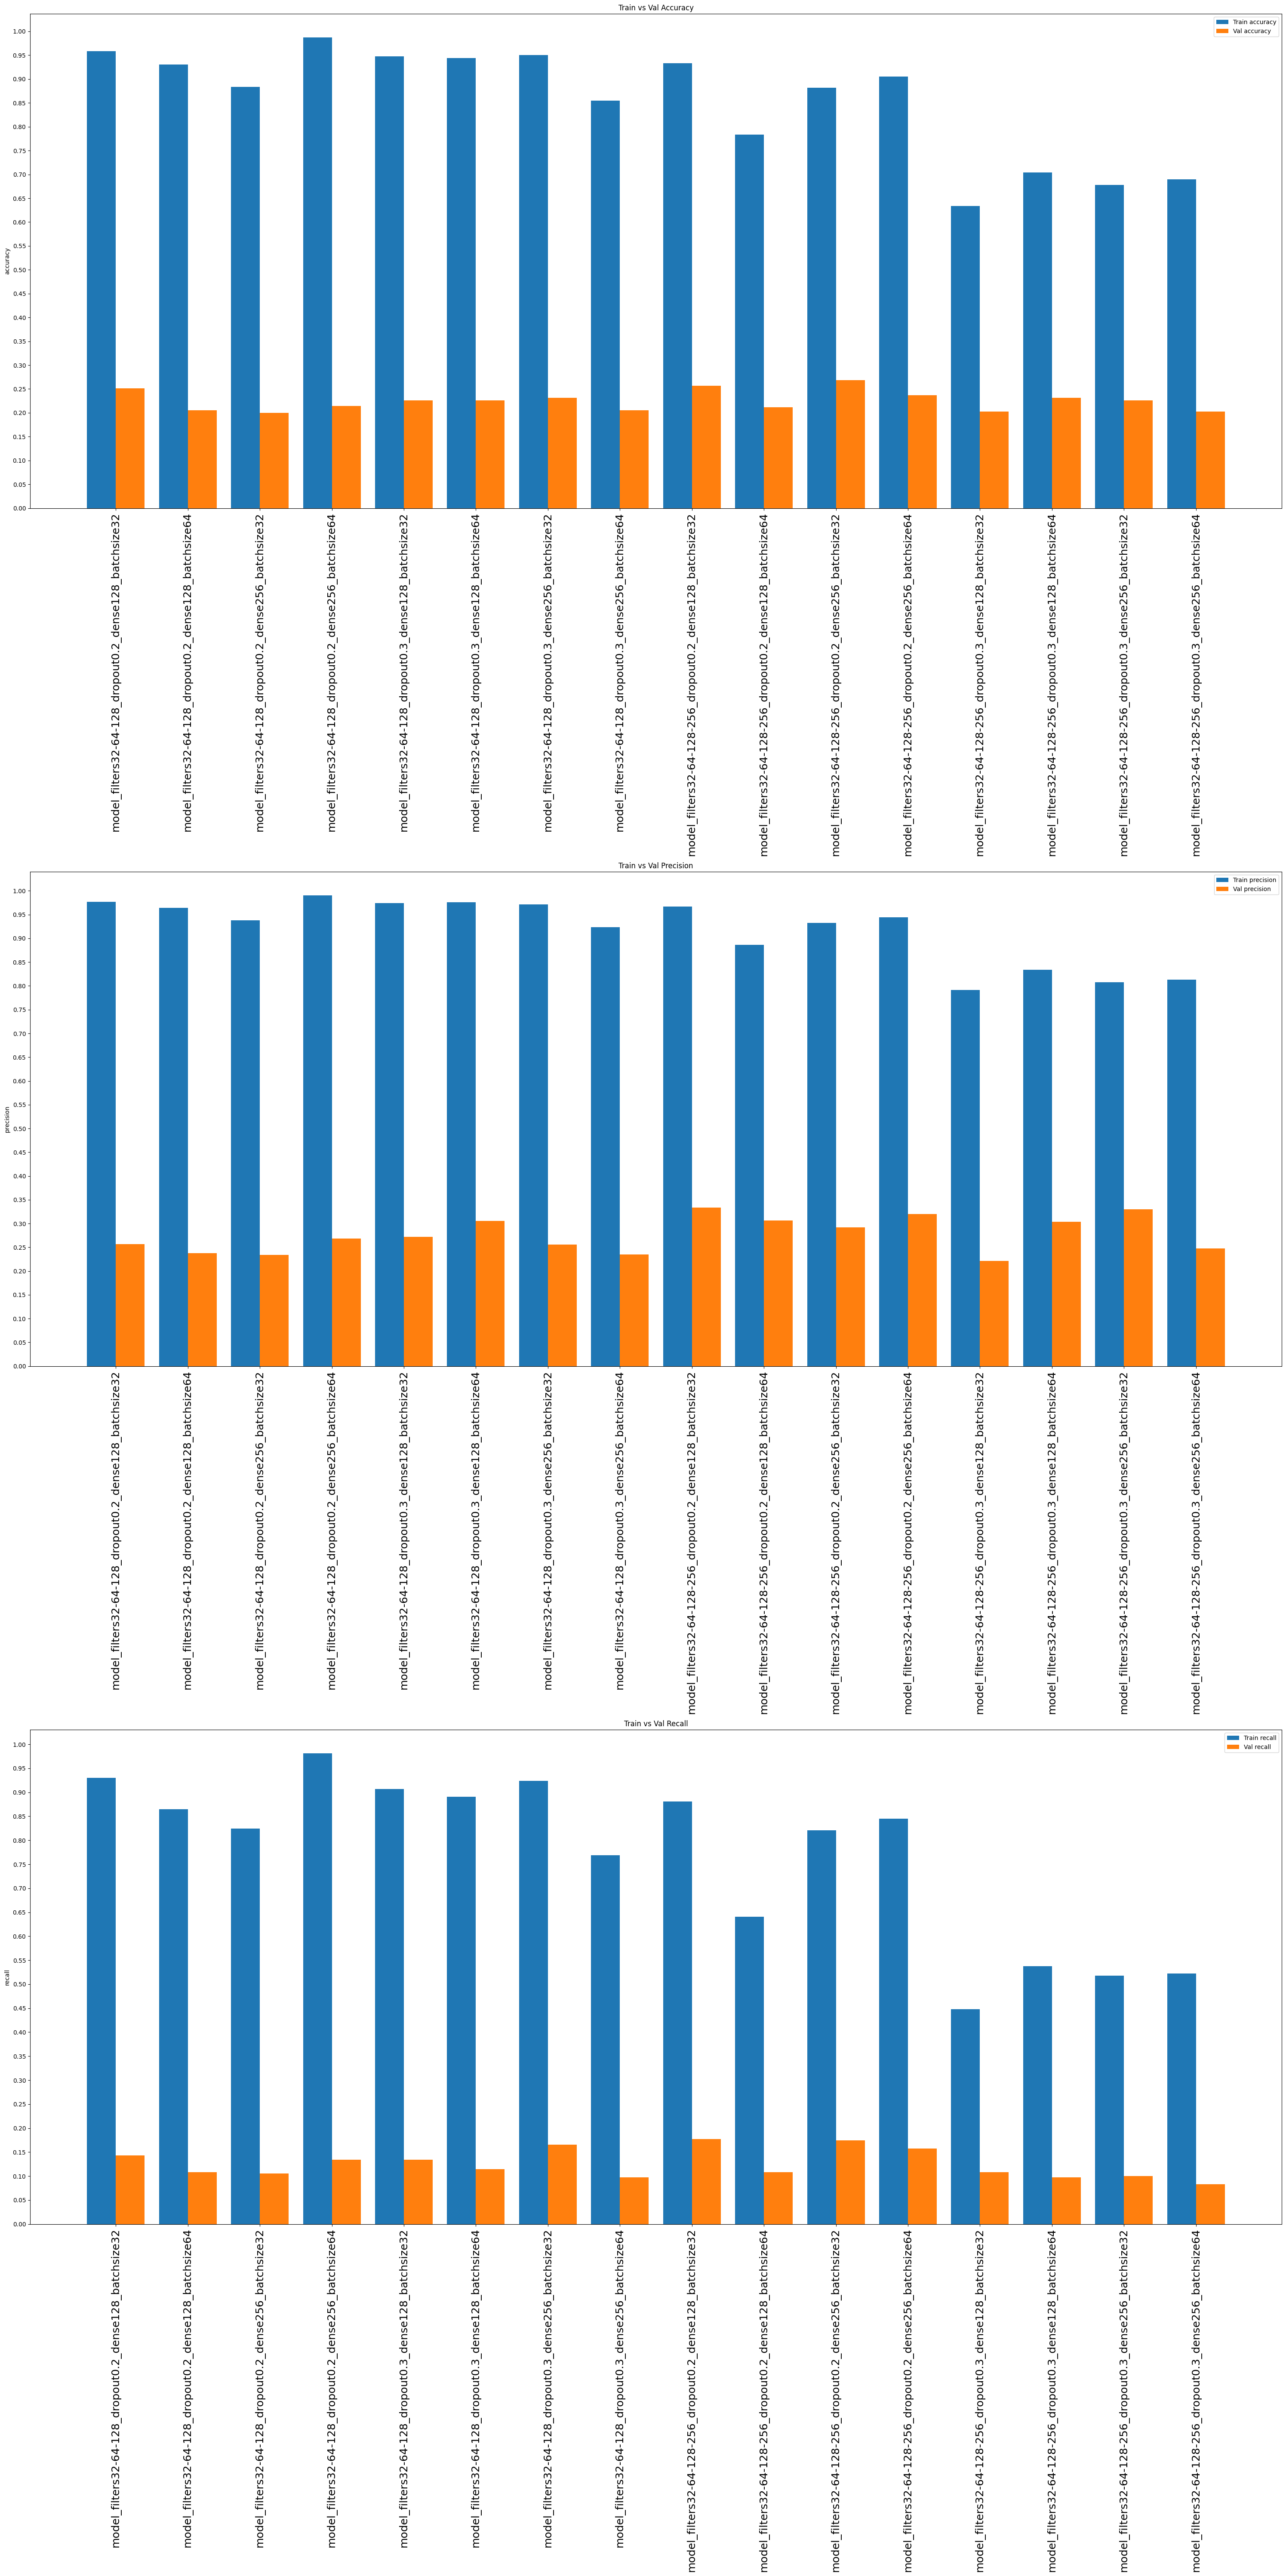

In [ ]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'precision', 'recall']
scores = {metric: {'train': [], 'val': []} for metric in metrics}
model_names = []

for model_name, metrics_data in results_loaded.items():
    model_names.append(model_name)
    for metric in metrics:
        scores[metric]['train'].append(metrics_data[f'train_{metric}'])
        scores[metric]['val'].append(metrics_data[f'val_{metric}'])

# Plotting
fig, axs = plt.subplots(len(metrics), figsize=(30, 60))
for i, metric in enumerate(metrics):
    axs[i].bar(model_names, scores[metric]['train'], width=-0.4, align='edge', label=f'Train {metric}')
    axs[i].bar(model_names, scores[metric]['val'], width=0.4, align='edge', label=f'Val {metric}')
    axs[i].set_ylabel(metric)
    axs[i].set_yticks(np.arange(0.0, 1.05, 0.05))
    axs[i].set_xticks(range(len(model_names)))
    axs[i].set_xticklabels(model_names, rotation=90, fontsize=18)
    axs[i].set_title(f'Train vs Val {metric.capitalize()}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
best_val_accuracy = 0
best_model_name = None

for model_name, history_dict in results_loaded.items():
    if history_dict['val_accuracy'] > best_val_accuracy:
        best_val_accuracy = history_dict['val_accuracy']
        best_model_name = model_name

print(f"Best Model: {best_model_name}")
print(f"Validation Accuracy: {best_val_accuracy}")


Best Model: model_filters32-64-128-256_dropout0.2_dense256_batchsize32
Validation Accuracy: 0.2685714364051819


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

best_drop_out_rate = 0.2
best_dense_neurons = 128
best_conv_filters = [32, 64, 128]
best_batch_size = 32
rotation_ranges = [10, 20, 30]

rotations_dict = []
for rotation_range in rotation_ranges:

    model_name = f"rotation_range{rotation_range}"
    path_model = f"./Results/{model_name}.h5"
    print(f"Training model: {model_name}")

    model = build_model(input_shape=shape, conv_filters=best_conv_filters, dropout_rate=best_drop_out_rate, dense_neurons=best_dense_neurons, num_classes=7)

    callbacks_list = [
        ModelCheckpoint(filepath=path_model, save_best_only=True),
        # EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    ]

    # history = model.fit(X_train, y_train, epochs=30, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=2, shuffle=True, callbacks=callbacks_list)

    train_datagen = ImageDataGenerator(
                      rescale=1./255, # Normalization
                      rotation_range=rotation_range, # Roatate images
                  )

    # For test set only normalize
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train, batch_size=best_batch_size)
    validation_generator = test_datagen.flow(X_test, y_test, batch_size=best_batch_size)

    history = model.fit(
        train_generator,
        # steps_per_epoch=len(X_train),
        verbose=2,
        epochs=20,
        validation_data=validation_generator,
        # validation_steps=len(X_test),
        # callbacks=[ModelCheckpoint(filepath=path_model)]
    )

    best_history_dict = {
        "train_accuracy": history.history.get('accuracy', [None])[-1],
        "val_accuracy": history.history.get('val_accuracy', [None])[-1],
        "train_precision": history.history.get('precision', [None])[-1],
        "val_precision": history.history.get('val_precision', [None])[-1],
        "train_recall": history.history.get('recall', [None])[-1],
        "val_recall": history.history.get('val_recall', [None])[-1]
    }
    rotations_dict.append(best_history_dict)

Training model: rotation_range10
Epoch 1/20
912/912 - 26s - loss: 1.6772 - accuracy: 0.3709 - precision: 0.5604 - recall: 0.1725 - val_loss: 1.3636 - val_accuracy: 0.4857 - val_precision: 0.7355 - val_recall: 0.2549 - 26s/epoch - 29ms/step
Epoch 2/20
912/912 - 16s - loss: 1.3392 - accuracy: 0.4869 - precision: 0.7040 - recall: 0.2782 - val_loss: 1.3503 - val_accuracy: 0.4798 - val_precision: 0.6938 - val_recall: 0.2845 - 16s/epoch - 17ms/step
Epoch 3/20
912/912 - 16s - loss: 1.2021 - accuracy: 0.5459 - precision: 0.7368 - recall: 0.3474 - val_loss: 1.4212 - val_accuracy: 0.4668 - val_precision: 0.6385 - val_recall: 0.3221 - 16s/epoch - 17ms/step
Epoch 4/20
912/912 - 16s - loss: 1.0939 - accuracy: 0.5900 - precision: 0.7546 - recall: 0.4104 - val_loss: 1.0876 - val_accuracy: 0.5878 - val_precision: 0.7626 - val_recall: 0.4301 - 16s/epoch - 17ms/step
Epoch 5/20
912/912 - 16s - loss: 1.0155 - accuracy: 0.6209 - precision: 0.7660 - recall: 0.4611 - val_loss: 1.3118 - val_accuracy: 0.5412 -

NameError: name 'json' is not defined

In [ ]:
import json
with open(f"./Results/{model_name}.json", "w") as f:
    json.dump(rotations_dict, f)


{'rotation10': {'train_accuracy': 0.8818668127059937, 'val_accuracy': 0.6059858202934265, 'train_precision': 0.9000500440597534, 'val_precision': 0.6364249587059021, 'train_recall': 0.8633838295936584, 'val_recall': 0.5822277069091797}}


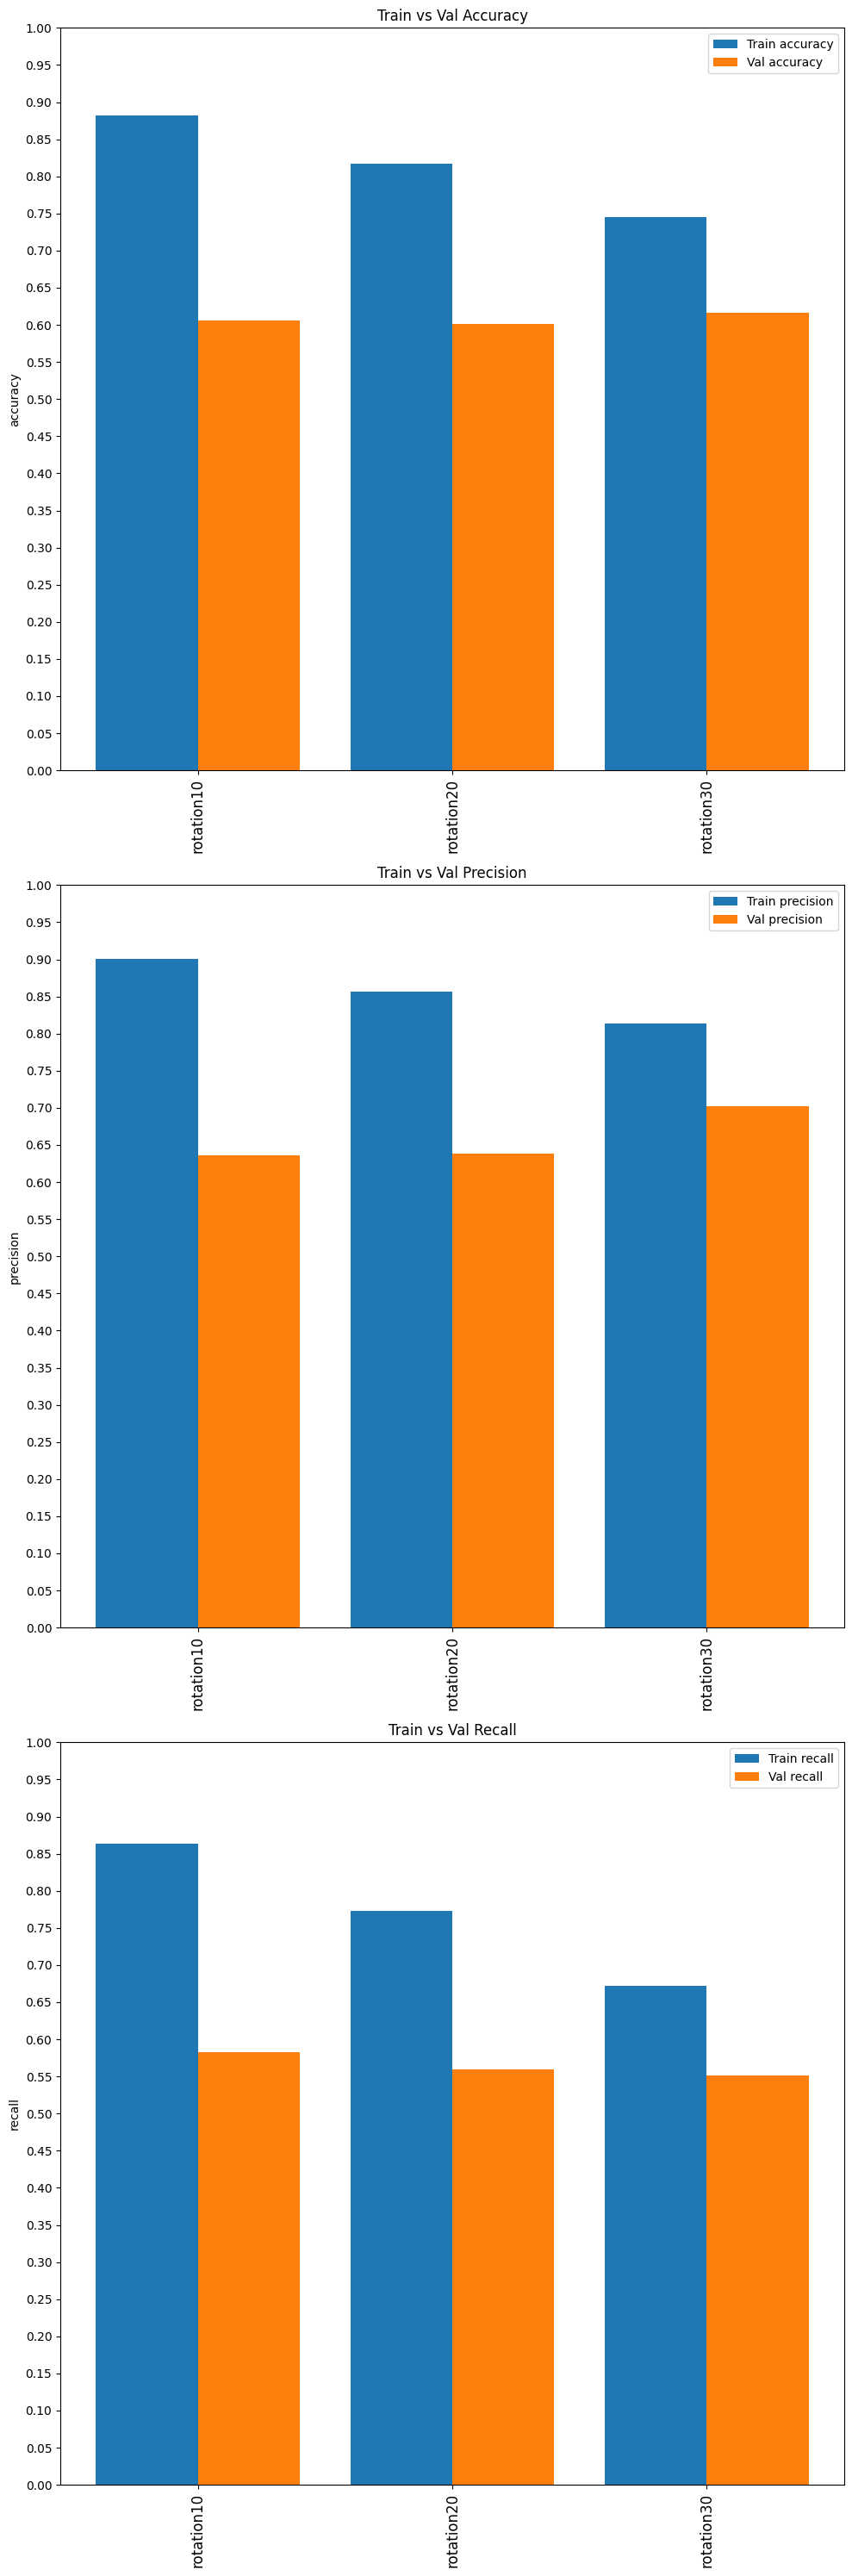

In [ ]:
import matplotlib.pyplot as plt
json_path = "./Results/Non-transfer-CNN/fer-2013/rotation/rotations.json"
with open (f"{json_path}", "r") as f:
    results_loaded = json.load(f)

print(results_loaded[0])
metrics = ['accuracy', 'precision', 'recall']
scores = {metric: {'train': [], 'val': []} for metric in metrics}
model_names = []

for model_data in results_loaded:
    for model_name, metrics_data in model_data.items():
        model_names.append(model_name)
        for metric in metrics:
            scores[metric]['train'].append(metrics_data[f'train_{metric}'])
            scores[metric]['val'].append(metrics_data[f'val_{metric}'])

# Plotting
fig, axs = plt.subplots(len(metrics), figsize=(10, 30))
for i, metric in enumerate(metrics):
    axs[i].bar(model_names, scores[metric]['train'], width=-0.4, align='edge', label=f'Train {metric}')
    axs[i].bar(model_names, scores[metric]['val'], width=0.4, align='edge', label=f'Val {metric}')
    axs[i].set_ylabel(metric)
    axs[i].set_yticks(np.arange(0.0, 1.05, 0.05))
    axs[i].set_xticks(range(len(model_names)))
    axs[i].set_xticklabels(model_names, rotation=90, fontsize=12)
    axs[i].set_title(f'Train vs Val {metric.capitalize()}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
best_rotation_range = 20

model_name = f"rotation_range{best_rotation_range}"
path_model = f"./Results/{model_name}.h5"
print(f"Training model: {model_name}")

model = build_model(input_shape=shape, conv_filters=best_conv_filters, dropout_rate=best_drop_out_rate, dense_neurons=best_dense_neurons, num_classes=7)

callbacks_list = [
    # ModelCheckpoint(filepath=path_model, save_best_only=True),
    # EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]

# history = model.fit(X_train, y_train, epochs=30, batch_size=best_batch_size, validation_data=(X_test, y_test), verbose=2, shuffle=True, callbacks=callbacks_list)

train_datagen = ImageDataGenerator(
                  rescale=1./255, # Normalization
                  rotation_range=best_rotation_range, # Roatate images
              )

# For test set only normalize
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=best_batch_size)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=best_batch_size)

history = model.fit(
    train_generator,
    # steps_per_epoch=len(X_train),
    verbose=2,
    epochs=20,
    validation_data=validation_generator,
    # validation_steps=len(X_test),
    # callbacks=[ModelCheckpoint(filepath=path_model)]
)

best_history_dict = {
    "train_accuracy": history.history.get('accuracy', [None])[-1],
    "val_accuracy": history.history.get('val_accuracy', [None])[-1],
    "train_precision": history.history.get('precision', [None])[-1],
    "val_precision": history.history.get('val_precision', [None])[-1],
    "train_recall": history.history.get('recall', [None])[-1],
    "val_recall": history.history.get('val_recall', [None])[-1]
}

Training model: rotation_range20
Epoch 1/20
912/912 - 19s - loss: 1.7271 - accuracy: 0.3493 - precision: 0.5253 - recall: 0.1465 - val_loss: 1.8929 - val_accuracy: 0.3931 - val_precision: 0.4609 - val_recall: 0.3089 - 19s/epoch - 21ms/step
Epoch 2/20
912/912 - 16s - loss: 1.3701 - accuracy: 0.4796 - precision: 0.6874 - recall: 0.2660 - val_loss: 1.2424 - val_accuracy: 0.5335 - val_precision: 0.7168 - val_recall: 0.3514 - 16s/epoch - 17ms/step
Epoch 3/20
912/912 - 17s - loss: 1.2305 - accuracy: 0.5330 - precision: 0.7320 - recall: 0.3276 - val_loss: 1.1834 - val_accuracy: 0.5440 - val_precision: 0.7558 - val_recall: 0.3696 - 17s/epoch - 19ms/step
Epoch 4/20
912/912 - 16s - loss: 1.1516 - accuracy: 0.5673 - precision: 0.7487 - recall: 0.3770 - val_loss: 1.2083 - val_accuracy: 0.5409 - val_precision: 0.6993 - val_recall: 0.3703 - 16s/epoch - 17ms/step
Epoch 5/20
912/912 - 16s - loss: 1.0959 - accuracy: 0.5869 - precision: 0.7481 - recall: 0.4098 - val_loss: 1.1330 - val_accuracy: 0.5705 -

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

label_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
inverse_label_map = {v: k for k, v in label_map.items()}

predicted_labels = model.predict(X_test)
predicted_classes = np.argmax(predicted_labels, axis=1)

predictions = [inverse_label_map[label] for label in predicted_classes]

true_labels = np.argmax(y_test, axis=1)

true_labels = [inverse_label_map[label] for label in true_labels]

102/102 [==============================] - 0s 2ms/step


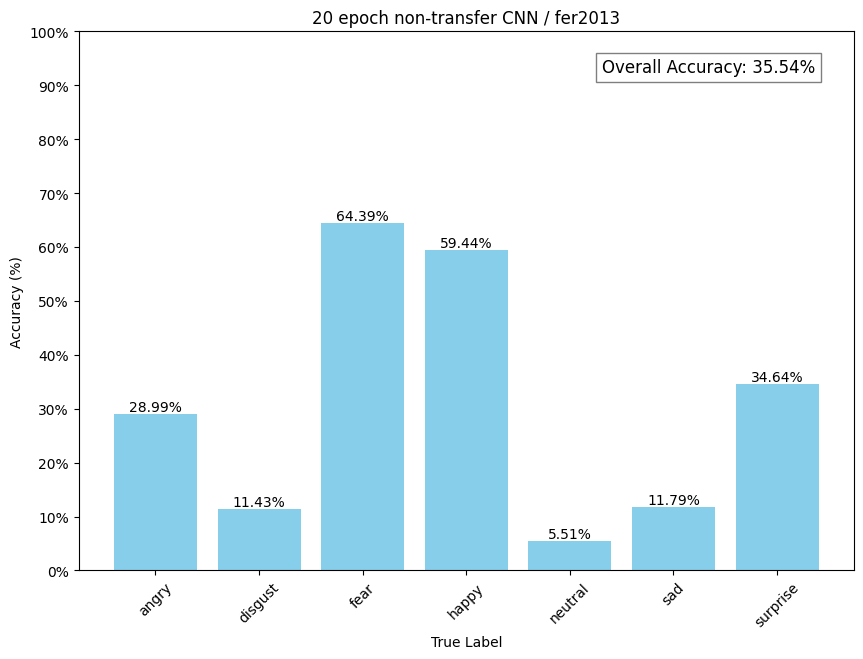

In [ ]:
plot_label_accuracies(np.array(true_labels), np.array(predictions), "20 epoch non-transfer CNN / fer2013")

<Axes: >

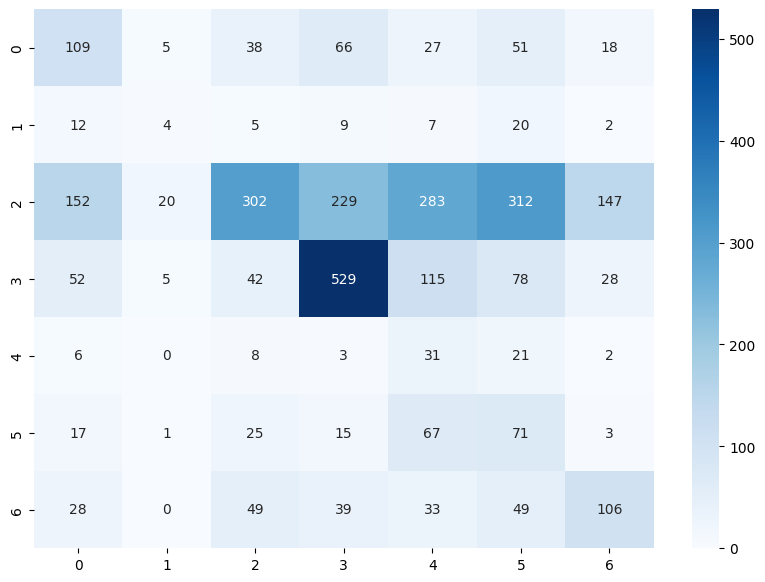

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns;

cm = confusion_matrix(np.array(predictions), np.array(true_labels))

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")